In [3]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds

## 1 Train CNN on the MNIST dataset
Since the MNIST dataset is very similar to the problem I am dealing with, I will use it to train a CNN model. As is shown in the following notebook the model is not sufficient for "my" hand-written digits. Altough it is used as a base in the transfer learning.

Model architecture is based on this [paper](https://www.bhu.ac.in/research_pub/jsr/Volumes/JSR_64_02_2020/51.pdf) (architecture 3) with some improvements introduced by myself (which improved the results on the transfer learning in the following notebook).

My improvements:
- Add batch normalization instead of dropout (for the convolutional layers)
- Use ELU activation function instead of rELU.
- Augmented dataset so it will generalize better

Architecture is simple but sufficient. I tested other hyperparameter values but those currently set turned out to be good.

In [4]:
train_data_raw = pd.read_csv('mnist/mnist_train.csv')
test_data_raw = pd.read_csv('mnist/mnist_test.csv')

X_train_root, X_valid_root, y_train_root, y_valid_root = train_test_split(train_data_raw.drop('label', axis=1), train_data_raw['label'], test_size=0.3, random_state=11)
X_test_root, y_test_root = test_data_raw.drop('label', axis=1), test_data_raw['label']

def get_dataset():
     return copy.deepcopy(X_train_root), copy.deepcopy(X_valid_root), copy.deepcopy(y_train_root), copy.deepcopy(y_valid_root)
    
def get_test_dataset():
    return copy.deepcopy(X_test_root), copy.deepcopy(y_test_root)

def get_merged_datasets():
    X_train, X_valid, y_train, y_valid = get_dataset()
    return vstack((X_train, X_valid)), np.concatenate([y_train, y_valid])

X_train, X_valid, y_train, y_valid = get_dataset()
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(42000, 784)
(42000,)
(18000, 784)
(18000,)


### Model

In [6]:
X_train, X_valid, y_train, y_valid = get_dataset()
X_train = (X_train > 128).astype(np.float32)
X_valid = (X_valid > 128).astype(np.float32)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_valid = X_valid.values.reshape(-1, 28, 28, 1)

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=False,
    zoom_range=0.1,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1
)
image_data_generator.fit(X_train)
augmented_iterator = image_data_generator.flow(X_train, y_train, batch_size=128)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=0)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Conv2D(64, (2, 2), activation='elu', padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='elu', padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='elu', padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer=tf.keras.optimizers.Adam())
model.fit(augmented_iterator, batch_size=128, epochs=50, validation_data=(X_valid, y_valid), verbose=1, callbacks=[early_stop])

Epoch 1/50


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - loss: 1.0076 - sparse_categorical_accuracy: 0.7194 - val_loss: 1.6089 - val_sparse_categorical_accuracy: 0.4949
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - loss: 0.3022 - sparse_categorical_accuracy: 0.9057 - val_loss: 0.1941 - val_sparse_categorical_accuracy: 0.9381
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.1314 - val_sparse_categorical_accuracy: 0.9612
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.2006 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.1306 - val_sparse_categorical_accuracy: 0.9619
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.8018
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.1929 - val_sparse_categorical_accuracy: 0.94

In [8]:
model.save('models/mnist-cnn.keras')

96% sparse categorical accuracy is solid.

In [9]:
X_test, y_test = get_test_dataset()
X_test = (X_test > 128).astype(np.float32)
X_test = X_test.values.reshape(-1, 28, 28, 1)

model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9602


[0.12300075590610504, 0.9639999866485596]

# 2 Show random predictions
## 2.1 From the MNIST training set

1 0.99981624


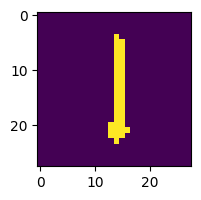

9 0.9914418


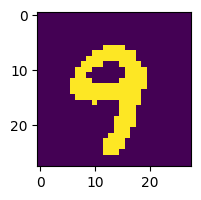

7 0.99978465


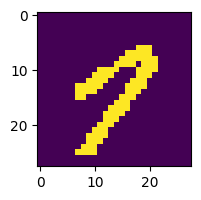

6 0.9939405


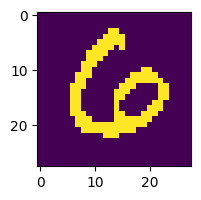

7 0.739885


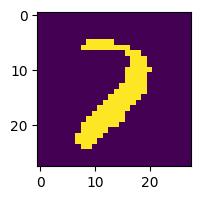

In [11]:
for i in range(10, 15):
    sample = X_train[i]
    img = X_train[i]

    sample = sample.reshape(1, 28, 28)
    res = model(sample)
    print(np.argmax(res), np.max(res))

    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()

## 2.2 From the custom hand-written digits obtained in the previous notebook
From the 100 images below can be seen that using this model is not possible. Mainly due to:
- Digits are too ugly
- Some of the characters can't be read even by me (e.g. 4th row), so I would add additional class representing the unreadable ones
- Even if the digit is nice, US style of some numbers is different (e.g. 1 is very often displayed only as a vertical line which is not the same in the Czech Republic)

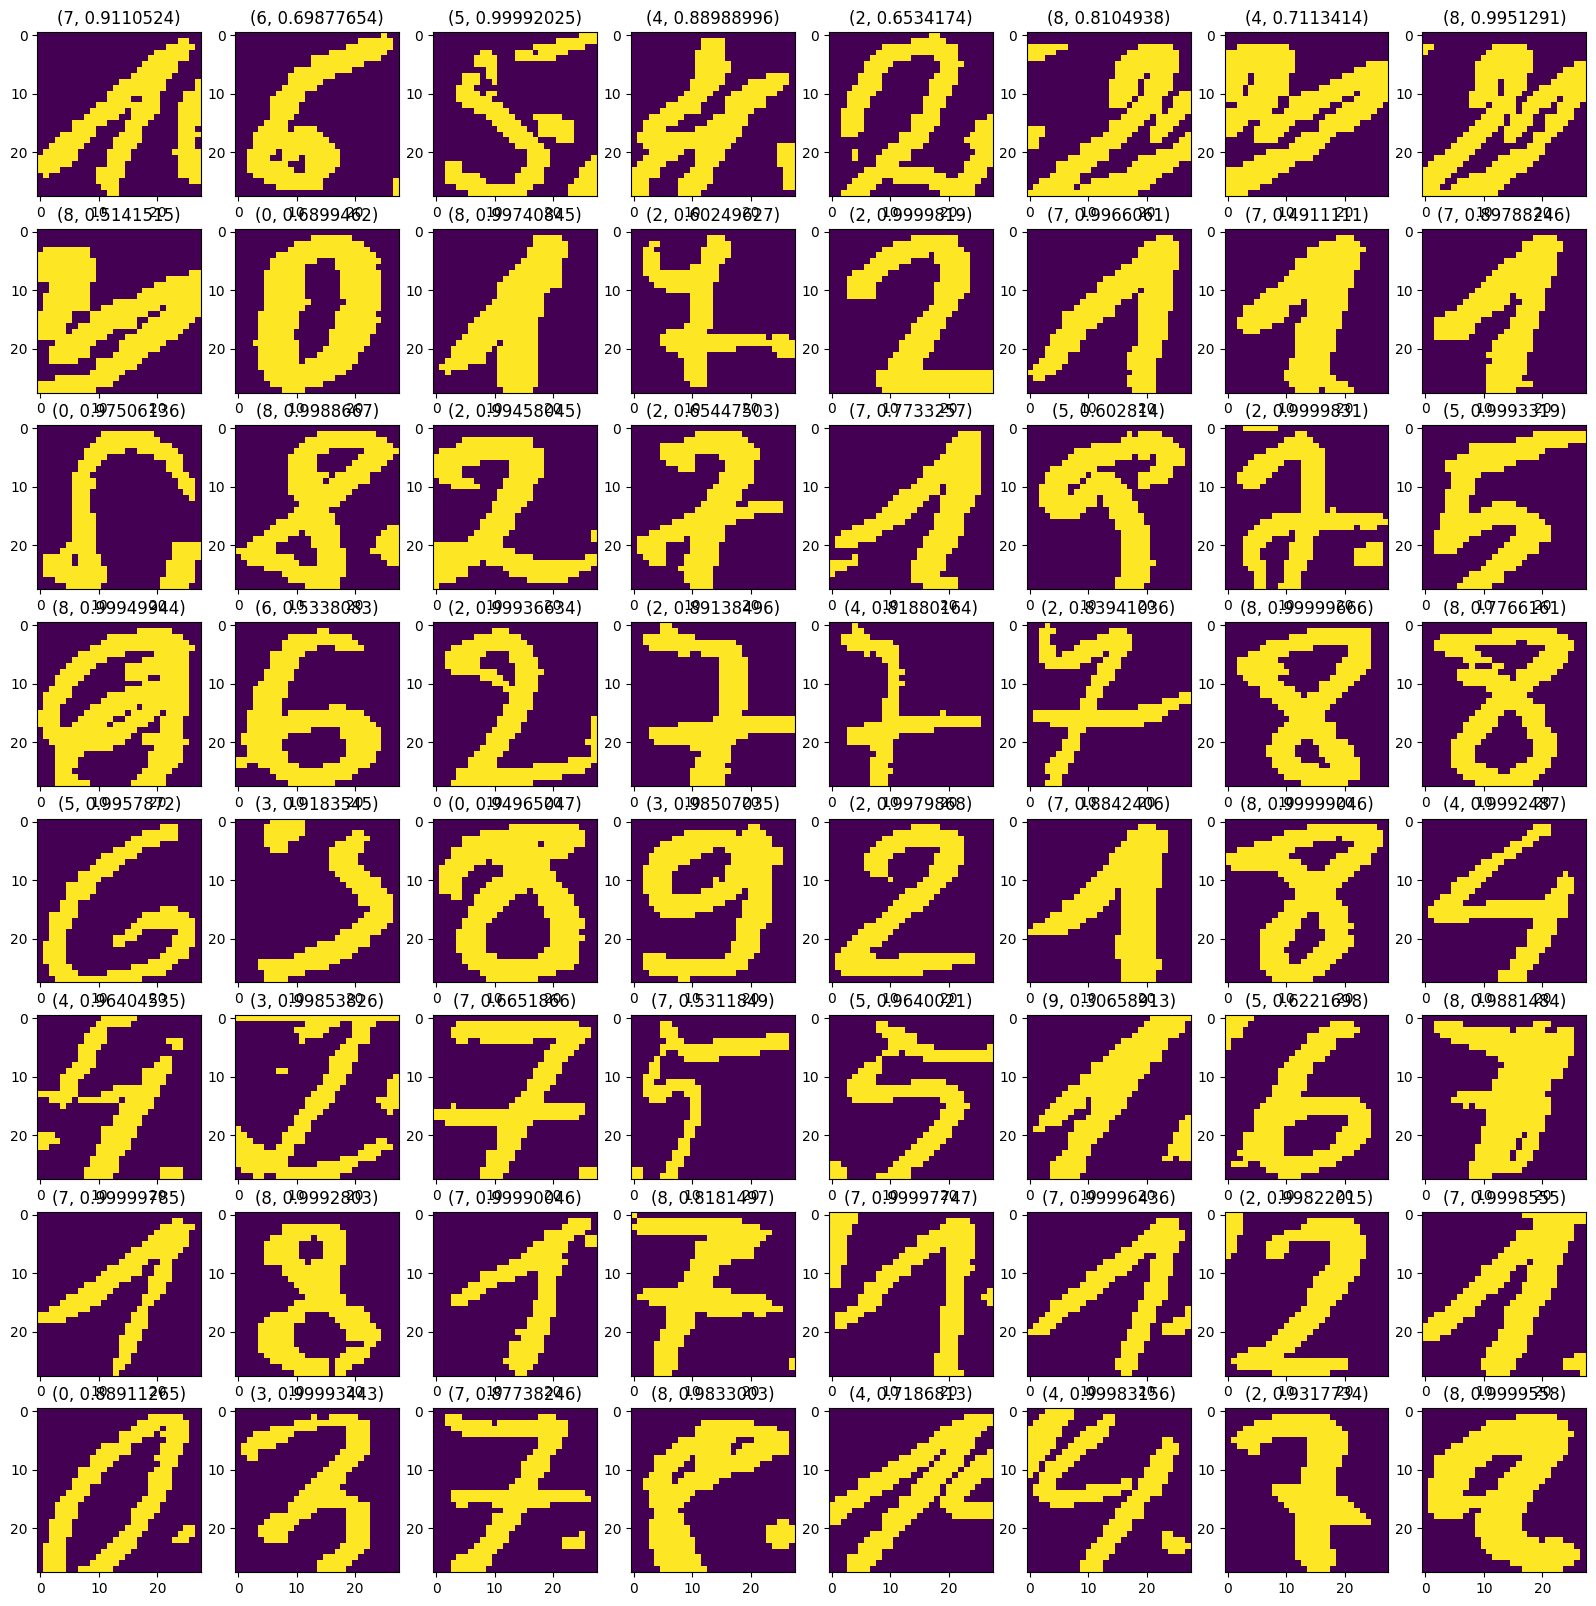

In [15]:
def get_id():
    for i in range(3000, 3100, 1):
        yield i

gen_id = get_id()
n_rows = 8
n_cols = 8

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row in range(n_rows):
    for col in range(n_cols):

        img = pd.read_csv('digits.csv').iloc[next(gen_id), :].to_numpy()
        # print(img)
        # print(img.shape)
        img = (img == 255).astype(np.float32)
        img = 1.0 - img
        img_show = img.reshape(28, 28)
        axs[row][col].imshow(img_show)
        
        
        img = img.reshape(-1, 28, 28, 1)
        res = model(img)
        axs[row][col].set_title((np.argmax(res), np.max(res)))